In [11]:
import random
import pandas as pd

import psycopg2 as pg
import sqlalchemy


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.weight': 'bold'})

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None



In [12]:
from sqlalchemy import create_engine

POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres'
POSTGRES_PASSWORD = 'postgres'
POSTGRES_DBNAME = 'mam'

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))

cnx = create_engine(postgres_str)

# Select first 5 rows
pd.read_sql_query('''SELECT * FROM scalars LIMIT 5;''', cnx)



,node_amount,area_sq_m,lpn_fn_ratio,relay_type,delta_ms,speed_ms,series,rep,module,name,type,value,full_row,created_at
0,50,1000,8,MAMRELAY,2,14,5,0,,configname,runattr,None,MAM_n50_a1000m2_lpnFn8_5-MAMRELAY-5-20201226-1...,2020-12-28
1,50,1000,8,MAMRELAY,2,14,5,0,,datetime,runattr,None,MAM_n50_a1000m2_lpnFn8_5-MAMRELAY-5-20201226-1...,2020-12-28
2,50,1000,8,MAMRELAY,2,14,5,0,,experiment,runattr,None,MAM_n50_a1000m2_lpnFn8_5-MAMRELAY-5-20201226-1...,2020-12-28
3,50,1000,8,MAMRELAY,2,14,5,0,,inifile,runattr,None,MAM_n50_a1000m2_lpnFn8_5-MAMRELAY-5-20201226-1...,2020-12-28
4,50,1000,8,MAMRELAY,2,14,5,0,,iterationvars,runattr,None,MAM_n50_a1000m2_lpnFn8_5-MAMRELAY-5-20201226-1...,2020-12-28


In [38]:
# Select distinct name values (https://wiki.postgresql.org/wiki/Loose_indexscan)
allNames = pd.read_sql_query('''
WITH RECURSIVE t AS (
   SELECT min(name) AS name FROM scalars
   UNION ALL
   SELECT (SELECT min(name) FROM scalars WHERE name > t.name)
   FROM t WHERE t.name IS NOT NULL
   )
SELECT name FROM t WHERE name IS NOT NULL
UNION ALL
SELECT null WHERE EXISTS(SELECT 1 FROM scalars WHERE name IS NULL);
''', cnx)['name']

allNames

0            *.collector*.app[0].destPort
1           *.collector*.app[0].localPort
2           *.collector*.app[0].startTime
3            *.collector*.app[0].typename
4          *.collector*.ipv4.arp.typename
                      ...                
163             symbolErrorRate:histogram
164                    transmission count
165               transmissionState:count
166    unique data packets bytes received
167          unique data packets received
Name: name, Length: 168, dtype: object

In [112]:
trackedNames = [
    'realDataEndToEndDelay:histogram', 
    'residualEnergyCapacity:last', 
    'unique data packets bytes received', 
    'repeated data packets bytes received'
]

trackedPrefixes = [
    'generated packet uuids-part',
    'received packet uuids-part'
]

for x in allNames:
    for y in trackedPrefixes:
        if x.startswith(y):
            trackedNames.append(x)
            

trackedNames

['realDataEndToEndDelay:histogram',
 'residualEnergyCapacity:last',
 'unique data packets bytes received',
 'repeated data packets bytes received',
 'generated packet uuids-part1',
 'generated packet uuids-part2',
 'generated packet uuids-part3',
 'received packet uuids-part1',
 'received packet uuids-part10',
 'received packet uuids-part11',
 'received packet uuids-part2',
 'received packet uuids-part3',
 'received packet uuids-part4',
 'received packet uuids-part5',
 'received packet uuids-part6',
 'received packet uuids-part7',
 'received packet uuids-part8',
 'received packet uuids-part9']

In [47]:
# Select distinct Delta values (https://wiki.postgresql.org/wiki/Loose_indexscan)
allDeltas = pd.read_sql_query('''
WITH RECURSIVE t AS (
   SELECT min(delta_ms) AS delta_ms FROM scalars
   UNION ALL
   SELECT (SELECT min(delta_ms) FROM scalars WHERE delta_ms > t.delta_ms)
   FROM t WHERE t.delta_ms IS NOT NULL
   )
SELECT delta_ms FROM t WHERE delta_ms IS NOT NULL
UNION ALL
SELECT null WHERE EXISTS(SELECT 1 FROM scalars WHERE delta_ms IS NULL);
''', cnx)

allDeltas = allDeltas['delta_ms']
#allDeltas = allDeltas[allDeltas <= 500]
#allDeltas = allDeltas[allDeltas != 2]

allDeltas.sort_values()

allDeltas

0         0
1         2
2         5
3        10
4        20
5        50
6       100
7       500
8      1000
9      5000
10    10000
11    15000
12    20000
Name: delta_ms, dtype: int64

In [48]:
primaryKeyColumns = ['node_amount', 'area_sq_m', 'lpn_fn_ratio', 'relay_type', 'delta_ms', 'speed_ms', 'series', 'rep']
primaryKeyColumnsCSV = ','.join(primaryKeyColumns)
tPrimaryKeyColumnsCSV = ','.join(['t.' + x for x in primaryKeyColumns])

allRuns = pd.read_sql_query('''
WITH RECURSIVE
     t AS (
  select ''' + primaryKeyColumnsCSV + ''' from
    (select ''' + primaryKeyColumnsCSV + ''' from scalars
    order by ''' + primaryKeyColumnsCSV + ''' limit 1) asdf
  union all
  select '''
     +
     ','.join(['(select ' + x + ' from scalars where (' + primaryKeyColumnsCSV + ') > (' + tPrimaryKeyColumnsCSV + ') order by ' + primaryKeyColumnsCSV + ' limit 1)' for x in primaryKeyColumns])
     +                       
  '''from t where t.''' + primaryKeyColumns[0] + ''' is not null)
select * from t where t.''' + primaryKeyColumns[0] + ''' is not null;
''', cnx)
allRuns

,node_amount,area_sq_m,lpn_fn_ratio,relay_type,delta_ms,speed_ms,series,rep
0,50,400,4,BMRELAY,0,2,0,0
1,50,400,4,BMRELAY,0,2,1,0
2,50,400,4,BMRELAY,0,2,2,0
3,50,400,4,BMRELAY,0,2,3,0
4,50,400,4,BMRELAY,0,2,4,0
...,...,...,...,...,...,...,...,...
11067,200,1000,12,MAMRELAY,20000,14,5,0
11068,200,1000,12,MAMRELAY,20000,14,6,0
11069,200,1000,12,MAMRELAY,20000,14,7,0
11070,200,1000,12,MAMRELAY,20000,14,8,0


In [51]:
pd.read_sql_query('''
SELECT count(*) from scalars where delta_ms=100 and name in (''' + ','.join(["'" + x + "'" for x in trackedNames]) + ''')
limit 10
''', cnx)



,count
0,189279


In [60]:
pd.read_sql_query('''
SELECT delta_ms,relay_type,lpn_fn_ratio,sum(cast(value as DOUBLE PRECISION)) from scalars where name='residualEnergyCapacity:last' group by delta_ms,relay_type,lpn_fn_ratio
''', cnx)

,delta_ms,relay_type,lpn_fn_ratio,sum
0,0,BMRELAY,4,-48620.263677
1,0,BMRELAY,8,-34583.575800
2,0,BMRELAY,12,-28301.724869
3,0,MAMRELAY,4,-15265.914491
4,0,MAMRELAY,8,-15004.474681
5,0,MAMRELAY,12,-14979.254045
6,2,MAMRELAY,4,-15177.673663
7,2,MAMRELAY,8,-15060.575535
8,2,MAMRELAY,12,-15038.833370
9,5,MAMRELAY,4,-15020.635922


In [108]:
BP_QUERY_SUFFIX = '''
details AS (
SELECT series,
       value,
       ROW_NUMBER() OVER (PARTITION BY series ORDER BY value) AS row_number,
       SUM(1) OVER (PARTITION BY series) AS total
  FROM raw_data
),

quartiles AS (
SELECT series,
       value,
       AVG(CASE WHEN row_number >= (FLOOR(total/2.0)/2.0) 
                 AND row_number <= (FLOOR(total/2.0)/2.0) + 1 
                THEN value/1.0 ELSE NULL END
          ) OVER (PARTITION BY series) AS q1,
       AVG(CASE WHEN row_number >= (total/2.0) 
                 AND row_number <= (total/2.0) + 1 
                THEN value/1.0 ELSE NULL END
          ) OVER (PARTITION BY series) AS median,
       AVG(CASE WHEN row_number >= (CEIL(total/2.0) + (FLOOR(total/2.0)/2.0))
                 AND row_number <= (CEIL(total/2.0) + (FLOOR(total/2.0)/2.0) + 1) 
                THEN value/1.0 ELSE NULL END
          ) OVER (PARTITION BY series) AS q3
  FROM details
)

SELECT series,
       MIN(value) AS minimum,
       AVG(q1) AS q1,
       AVG(median) AS median,
       AVG(q3) AS q3,
       MAX(value) AS maximum
  FROM quartiles
 GROUP BY 1
 ORDER BY 4
'''

energyDrawBPdata = pd.read_sql_query('''
WITH raw_data AS (

SELECT CONCAT(relay_type,'-',lpn_fn_ratio) as series, cast(value as DOUBLE PRECISION)*-1.0 as value 
      from scalars 
      where name='residualEnergyCapacity:last'
      
),
 
''' + BP_QUERY_SUFFIX, cnx)

energyDrawBPdata

,series,minimum,q1,median,q3,maximum
0,MAMRELAY-12,0.000295,0.459400,0.499951,0.538752,1.950528
1,MAMRELAY-8,0.000142,0.459441,0.505953,0.550066,2.283924
2,MAMRELAY-4,0.000147,0.472863,0.519413,0.574688,4.494737
3,BMRELAY-12,0.034331,0.506076,0.693329,1.223284,5.823802
4,BMRELAY-8,0.000160,0.512867,0.905168,1.599817,5.703887
5,BMRELAY-4,0.065259,0.684930,1.598713,1.750594,5.665468


[Text(1, 0, 'MAM-LPN/FN=12'),
 Text(2, 0, 'MAM-LPN/FN=8'),
 Text(3, 0, 'MAM-LPN/FN=4'),
 Text(4, 0, 'BM-LPN/FN=12'),
 Text(5, 0, 'BM-LPN/FN=8'),
 Text(6, 0, 'BM-LPN/FN=4')]

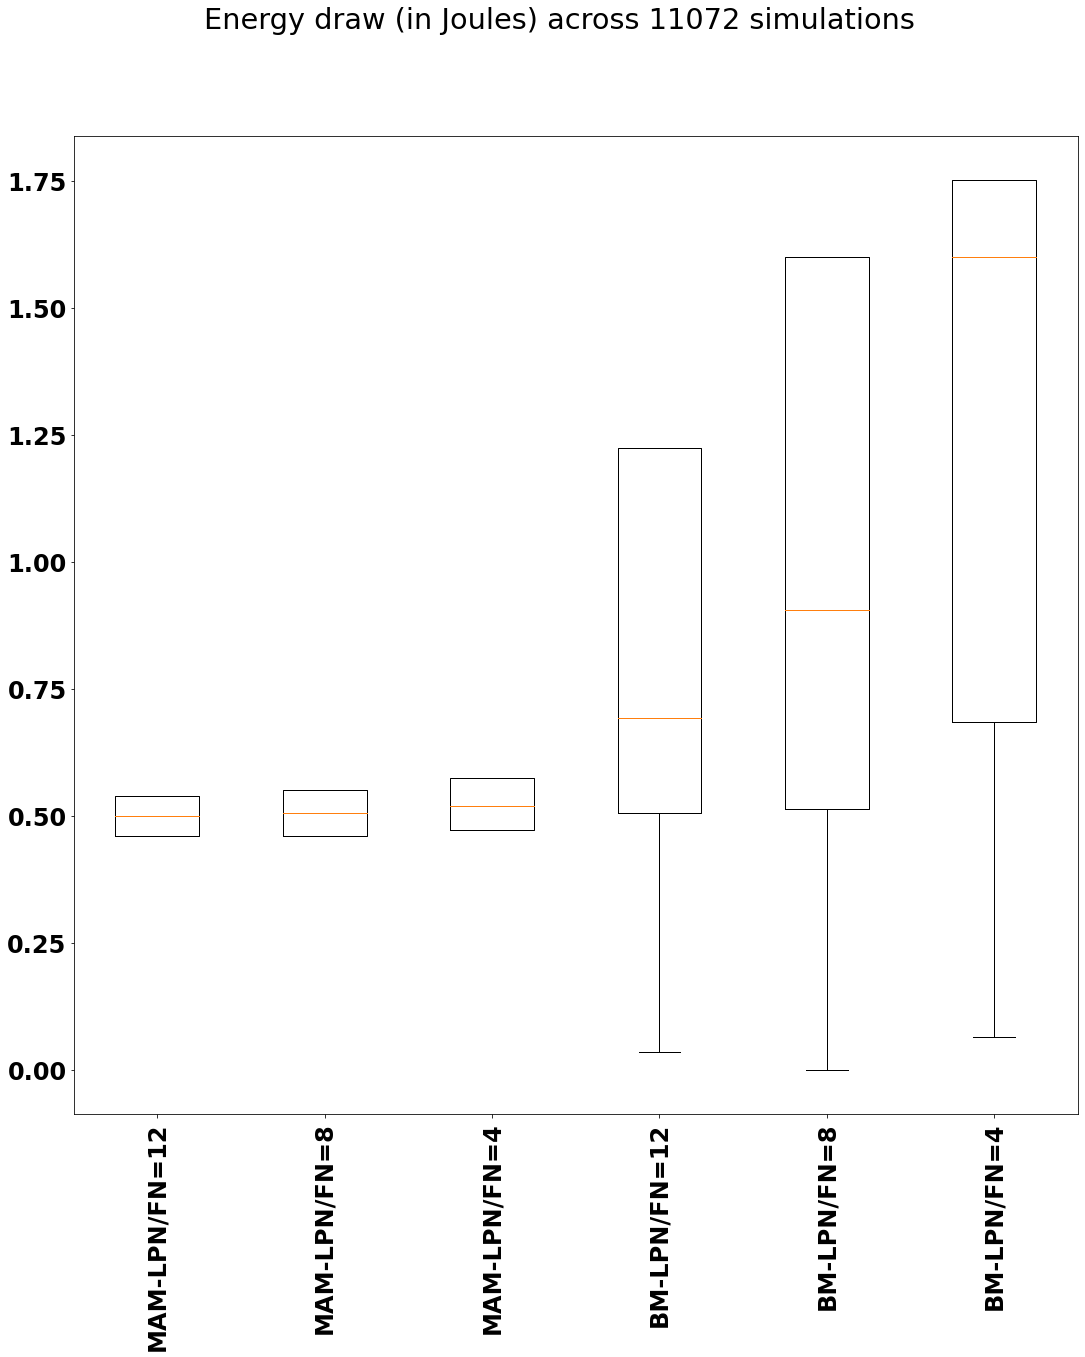

In [123]:
energyDrawBPdata

# Create a figure instance
fig = plt.figure(1, figsize=(18, 18))

# Create an axes instance
ax = fig.add_subplot(111)

labels = energyDrawBPdata['series'].str.replace('RELAY-','-LPN/FN=')

data = []

for row in energyDrawBPdata.iterrows():
    x = row[1]
    data.append([x['minimum'], x['q1'], x['median'], x['q3'], x['maximum']])

ax.boxplot(data, showfliers=False)

plt.suptitle('Energy draw (in Joules) across ' + str(len(allRuns)) + ' simulations')

plt.xticks(rotation='90.0')
ax.set_xticklabels(labels)


In [152]:
uniqueDataPacketsBPData = pd.read_sql_query('''
WITH raw_data AS (

SELECT CONCAT(relay_type,'-',delta_ms) as series, cast(value as DOUBLE PRECISION) as value 
      from scalars 
      where name='unique data packets bytes received'
      
),
 
''' + BP_QUERY_SUFFIX, cnx)

# We can see that the Delta=50/Delta=100 presented the best median values for MAM-RELAY (8778-8800), 
# which is similar to the behavior we noticed with the original tests (MAM50)

uniqueDataPacketsBPData['sortcol'] = pd.DataFrame(pd.to_numeric(uniqueDataPacketsBPData['series'].str.split('-').str[1]))
uniqueDataPacketsBPData = uniqueDataPacketsBPData.sort_values('sortcol')
uniqueDataPacketsBPData



,series,minimum,q1,median,q3,maximum,sortcol
0,MAMRELAY-0,1001.0,5786.0,8002.5,12738.0,29777.0,0
13,BMRELAY-0,1122.0,11242.0,18315.0,28061.0,65736.0,0
1,MAMRELAY-2,1089.0,5973.0,8096.0,12925.0,30657.0,2
3,MAMRELAY-5,1155.0,5885.0,8294.0,13299.0,34078.0,5
5,MAMRELAY-10,1012.0,6050.0,8338.0,13739.0,34067.0,10
10,MAMRELAY-20,1111.0,6154.5,8756.0,14003.0,35420.0,20
12,MAMRELAY-50,858.0,6160.0,8800.0,13997.5,38753.0,50
11,MAMRELAY-100,1144.0,6248.0,8778.0,14465.0,39545.0,100
9,MAMRELAY-500,1122.0,6237.0,8723.0,14586.0,65307.0,500
8,MAMRELAY-1000,1100.0,6105.0,8426.0,13552.0,35013.0,1000


[Text(1, 0, 'MAM-Δ=0'),
 Text(2, 0, 'BM-Δ=0'),
 Text(3, 0, 'MAM-Δ=2'),
 Text(4, 0, 'MAM-Δ=5'),
 Text(5, 0, 'MAM-Δ=10'),
 Text(6, 0, 'MAM-Δ=20'),
 Text(7, 0, 'MAM-Δ=50'),
 Text(8, 0, 'MAM-Δ=100'),
 Text(9, 0, 'MAM-Δ=500'),
 Text(10, 0, 'MAM-Δ=1000'),
 Text(11, 0, 'MAM-Δ=5000'),
 Text(12, 0, 'MAM-Δ=10000'),
 Text(13, 0, 'MAM-Δ=15000'),
 Text(14, 0, 'MAM-Δ=20000')]

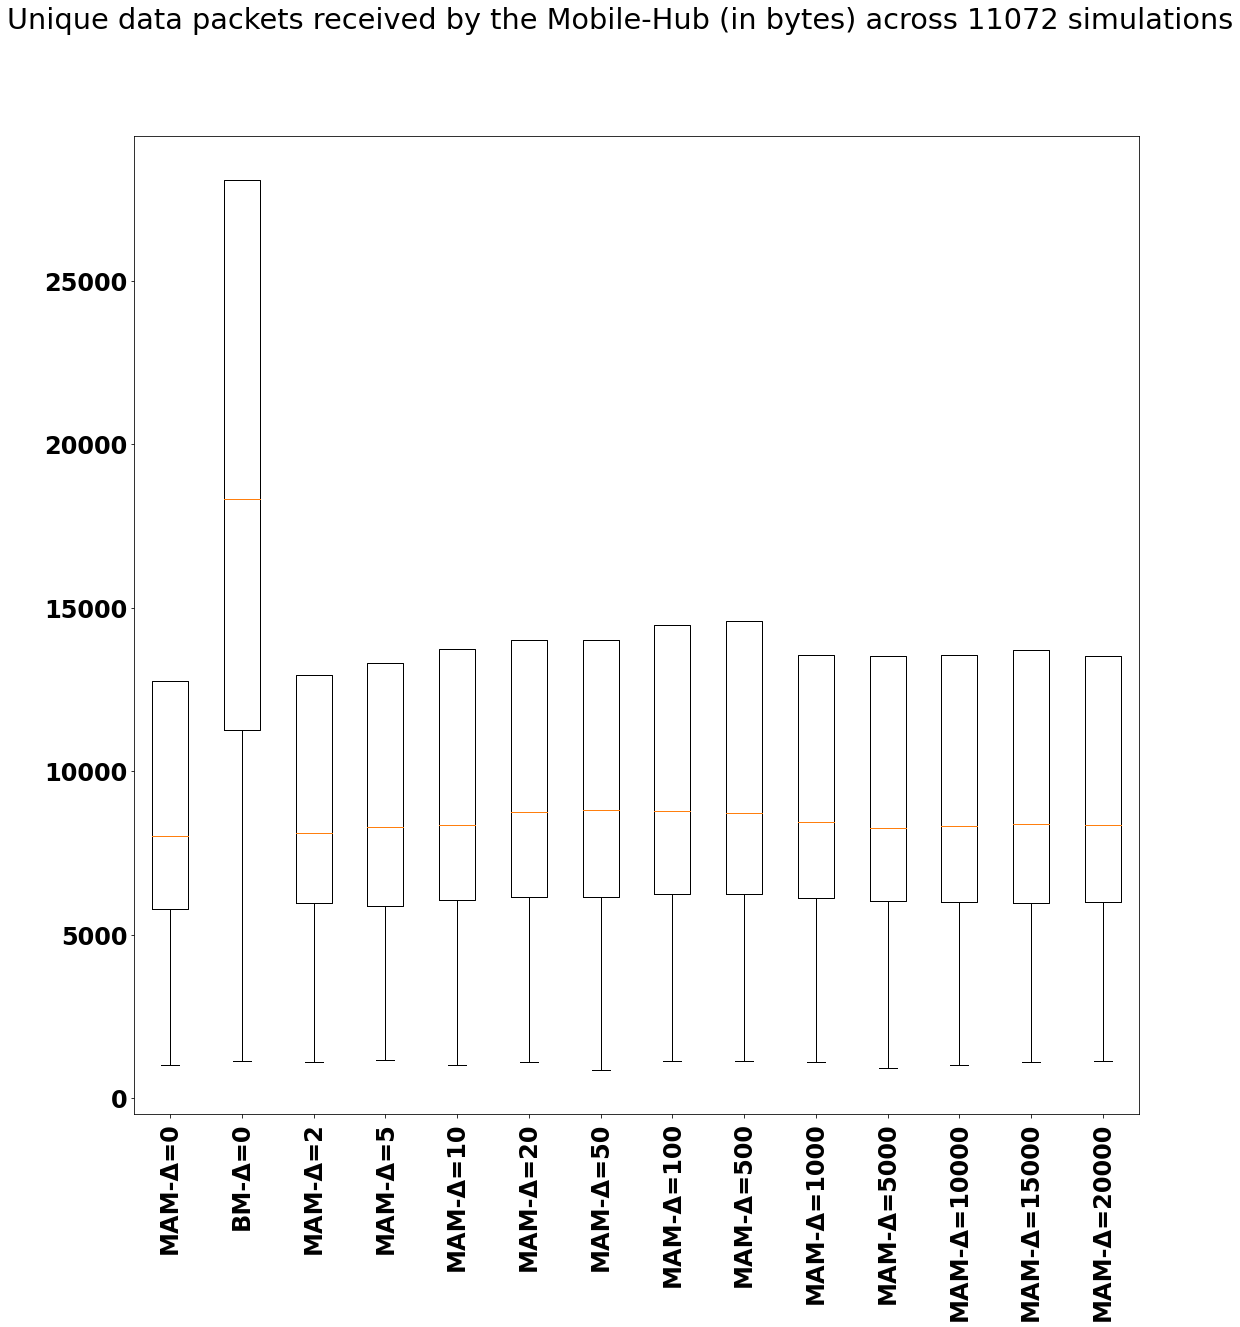

In [153]:
# Create a figure instance
fig = plt.figure(1, figsize=(18, 18))

# Create an axes instance
ax = fig.add_subplot(111)

labels = uniqueDataPacketsBPData['series'].str.replace('RELAY-','-Δ=')

data = []

for row in uniqueDataPacketsBPData.iterrows():
    x = row[1]
    data.append([x['minimum'], x['q1'], x['median'], x['q3'], x['maximum']])

ax.boxplot(data, showfliers=False)

plt.suptitle('Unique data packets received by the Mobile-Hub (in bytes) across ' + str(len(allRuns)) + ' simulations')

plt.xticks(rotation='90.0')
ax.set_xticklabels(labels)

In [ ]:

def findBluetoothRelayRun(speed, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"BMesh"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("Bluetooth Relay run not found for speed=" + str(speed) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("Bluetooth Relay run duplicate for speed=" + str(speed) + " configName=" + configName)
    return s.index[0]

findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY')



In [ ]:

def findMAMRelayRun(speed, delta, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"MAM"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        deltaMatch = x[(x.attrname == 'delta')]['attrvalue'].iloc[0] == delta
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & deltaMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("MAM Relay run not found for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("MAM Relay run duplicate for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    return s.index[0]

findMAMRelayRun(speed=2, delta=5, configName='MAM50-MAMRELAY')


In [ ]:
def getRunData(run):
    return aloha[aloha.run == run]

def getCollectorRunScalars(run):
    runData = aloha[aloha.run == run]
    runData = runData[(runData.type=='scalar')]
    return runData[runData['module'].str.contains('collector1.app')]

getRunData(findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY'))

In [ ]:
aloha.iloc[1200:1205]


In [ ]:
aloha.info()

In [ ]:
aloha.describe()

In [ ]:
scalars = aloha[(aloha.type=='scalar')]
scalars.head()


In [ ]:
runPrefix = 'MAM50-BMRELAY-0'
run2Prefix = 'MAM50-MAMRELAY-6'

In [ ]:
def getScalarSum(scalarName, runData):
    scalarData = runData[(runData.type=='scalar')]
    return scalarData[(scalarData.name==scalarName)]['value'].sum()

energyConsumptionSum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
energyConsumptionSum

In [ ]:
energyConsumption2Sum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
energyConsumption2Sum

In [ ]:
def getUniqueScalarValue(scalarName, scalarData):
    scalarValue = scalarData[(scalarData.name==scalarName)]['value']

    if len(scalarValue) > 1:
        raise Exception('Scalar ' + scalarName + ' is not unique on this dataframe')
    return scalarValue.iloc[0]

collectorPacketsReceived = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))

'Packets received (BM 2): ' + str(collectorPacketsReceived)

In [ ]:
collectorPacketsReceived2 = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Packets received (MAM 2 D5): ' + str(collectorPacketsReceived2)

In [ ]:
dataPacketsSent = getScalarSum('data packets sent', getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
dataPacketsSent2 = getScalarSum('data packets sent', getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Data packets sent (BM 2): ' + str(dataPacketsSent) + ' / Data packets sent (MAM 2 D5): ' + str(dataPacketsSent2)

In [ ]:
'Data packets sent (' + run2Prefix + '): ' + str(dataPacketsSent2)

In [ ]:
histograms = aloha[aloha.type=='histogram']
endToEndDelayHistograms = histograms[aloha.name=='realDataEndToEndDelay:histogram']
len(endToEndDelayHistograms)


In [ ]:
def getHistogramData(histogramName, runData):
    histograms = runData[runData.type == 'histogram']
    histogram = histograms[histograms.name == histogramName]
    if len(histogram) == 0:
        raise Exception('Histogram not found')
    if len(histogram) > 1:
        raise Exception('Histogram match not unique')
    return histogram.iloc[0]

hist = getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
hist

In [ ]:
hist2 = getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
hist2

In [ ]:
hist2.binedges, hist2.binvalues

In [ ]:

plt.hist(bins=hist.binedges, x=hist.binedges[:-1], weights=hist.binvalues, label="delay (ms)")
plt.legend(title=runPrefix)
plt.show()

plt.hist(bins=hist2.binedges, x=hist2.binedges[:-1], weights=hist2.binvalues, label="delay (ms)")
plt.legend(title=run2Prefix)
plt.show()

In [ ]:
hist = endToEndDelayHistograms[endToEndDelayHistograms['run'].str.startswith(runPrefix, na=False)].iloc[0]
hist

In [ ]:
str(100-energyConsumption2Sum/energyConsumptionSum*100) + '% ' + run2Prefix + ' energy efficiency compared to ' + runPrefix

In [ ]:
def explodeHistogramData(histogram):
    a = []

    i = 0
    for aa in histogram.binedges[:-1]:
        for j in range(1,histogram.binvalues[i].astype(np.int)):
            a.append(aa)
        i = i + 1
    return a

def getBoxPlotData(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh2mpsData = explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY'))))
    
data_to_plot_2ms = [bmesh2mpsData]
labels = ['BTM-R ★']

for d in allDeltas:
    data_to_plot_2ms.append(explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=d, configName='MAM50-MAMRELAY')))))
    if d == 0:
        labels.append('MAM-0')
    else:
        labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_2ms, showfliers=False)

ax.set_xticklabels(labels)

speed = 2
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')
ax.set_xticklabels(labels)
plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh6mpsData = explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=6, configName='MAM50-BMRELAY'))))

data_to_plot_6ms = [bmesh6mpsData]
labels = ['BTM-R ★']

for d in allDeltas:
    data_to_plot_6ms.append(explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=6, delta=d, configName='MAM50-MAMRELAY')))))
    if d == 0:
        labels.append('MAM-0')
    else:
        labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_6ms, showfliers=False)

ax.set_xticklabels(labels)

speed = 6
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')

plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('fig2.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

In [ ]:
bmesh14mpsData = explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=14, configName='MAM50-BMRELAY'))))
    
    
# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

data_to_plot_14ms = [bmesh14mpsData]
labels = ['BTM-R ★']

for d in allDeltas:
    data_to_plot_14ms.append(explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=14, delta=d, configName='MAM50-MAMRELAY')))))
    if d == 0:
        labels.append('MAM-0')
    else:
        labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_14ms, showfliers=False)

ax.set_xticklabels(labels)

speed = 14
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')


plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('fig3.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

In [ ]:
def getEnergyConsumptionData(speed):
    energyConsumptionSumBM = getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))


    labels = ['BTM-R ★']
    values = [-energyConsumptionSum]

    for d in allDeltas:
        values.append(-getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))))
        if d == 0:
            labels.append('MAM-0')
        else:
            labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def getBarChartData(labels, values):
    rows_list = []
    
    isDict = type(values) is dict
    
    if not isDict:
        for i in range(len(labels)):
            dict1 = {}
            dict1['label'] = labels[i]
            dict1['value'] = values[i]

            rows_list.append(dict1)
    else:
        for key in values:
            row = values[key]
            
            i = 0
            for ld in labels:
                dict1 = {}
                dict1['label'] = key + " - " + ld[0]
                dict1['value'] = row[i]
                rows_list.append(dict1)
                i = i + 1
        
    return pd.DataFrame(rows_list)

[labels, values] = getEnergyConsumptionData(2)
getBarChartData(labels, values)

In [ ]:
def plotEnergyConsumptionData(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')
        
    i = 0
    for p in bp.patches:
        if i > 0:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            perc = (values[i]-values[0])/values[0]
            ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
        i = i + 1

    plt.suptitle('Energy draw (' + str(speed) + 'm/s)')
    plt.xticks(rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight', dpi=150)
    
plotEnergyConsumptionData(labels, values, 2, 4)

In [ ]:
[labels, values] = getEnergyConsumptionData(6)
getBarChartData(labels, values)

In [ ]:
plotEnergyConsumptionData(labels, values, 6, 5)

In [ ]:
[labels, values] = getEnergyConsumptionData(14)
getBarChartData(labels, values)

In [ ]:
plotEnergyConsumptionData(labels, values, 14, 6)

In [ ]:
def getCollectorPacketsReceivedData(speed):
    bmData = getUniqueScalarValue(scalarName='unique data packets bytes received', 
                            scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))

    bmRepeatedData = getUniqueScalarValue(scalarName='repeated data packets bytes received', 
                            scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))

    labels = [['unique',u'#348ABD'], ['repeated',u'#A60628']]
    values = dict()
    values['BTM-R ★'] = [bmData, bmRepeatedData]
    #repeatedValues = [bmRepeatedData]

    for d in allDeltas:
        data = getUniqueScalarValue(scalarName='unique data packets bytes received', 
                            scalarData=getCollectorRunScalars(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY')))
        repeatedData = getUniqueScalarValue(scalarName='repeated data packets bytes received', 
                            scalarData=getCollectorRunScalars(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY')))
        
        if d == 0:
            values['MAM-0'] = [data,repeatedData]
        else:
            values['MAM-Δ=' + str(d)] = [data,repeatedData]
    return [labels, values]

def plotPacketsReceivedData(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))
    
    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels([], fontsize = 24)

    bp = []
    
    # Create the barchart
    i = 0
    for key,vals in values.items():
        j = len(vals)
        temp = sum(vals)
        for val in reversed(vals):
            tempBp = ax.bar(i, temp, color=labels[j - 1][1])
            
            if j == len(vals):
                bp.append(tempBp) # Only add the sum to the bp patches
            
            temp = temp - val
            j = j - 1
        i = i + 1


    labelNames = list()
    colors = dict()
    for labelData in labels:
        labelNames.append(labelData[0])
        colors[labelData[0]] = labelData[1]
        
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labelNames]
    plt.legend(handles, labelNames, prop={'weight': 'bold', 'size': 24})

    #bp[0].set_color('orange')
    
    i = 0
    for c in bp:
        for p in c.patches:
            if i > 0:
                width = p.get_width()
                height = p.get_height()
                x, y = p.get_xy() 
                vvalues = list(values.values())
                perc = (sum(vvalues[i])-(vvalues[0][0]))/(vvalues[0][0])
                ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
            i = i + 1

    plt.suptitle('M-Hub Received packets in bytes (' + str(speed) + 'm/s)', fontproperties={'weight': 'bold', 'size': 24})
    plt.xticks(range(len(values)), values.keys(), rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight', dpi=150)
    


In [ ]:
[labels, values] = getCollectorPacketsReceivedData(2)


In [ ]:
getBarChartData(labels, values)

In [ ]:
plotPacketsReceivedData(labels, values, 2, 7)

In [ ]:
[labels, values] = getCollectorPacketsReceivedData(6)
getBarChartData(labels, values)

In [ ]:
plotPacketsReceivedData(labels, values, 6, 8)

In [ ]:
[labels, values] = getCollectorPacketsReceivedData(14)
getBarChartData(labels, values)

In [ ]:
plotPacketsReceivedData(labels, values, 14, 9)

In [ ]:
def getReceivedPacketUUIDs(runData):
    packetUUIDs = set()

    data = runData[runData['name'].str.contains("received packet uuids-part1", na=False)]

    i = 1
    while len(data) > 0:
        if len(data) > 1:
            raise Exception('Error - non unique uuid part')

        key = data.iloc[0]['name']
        uuidsPartial = key.split('=')[1].split(',')
        packetUUIDs.update(uuidsPartial)
        i = i + 1
        data = runData[runData['name'].str.contains("received packet uuids-part" + str(i), na=False)]

    return packetUUIDs

def getGeneratedPacketUUIDs(runData):
    packetUUIDs = set()

    #data = runData[runData['name'].str.contains("generated packet uuids", na=False)]['name']
    
    #data.apply(lambda x: packetUUIDs.update(x.replace('generated packet uuids','').split(',')))
    
    data = runData[runData['name'].str.contains("generated packet uuids-part1", na=False)]

    i = 1
    while len(data) > 0:
        for j in range(0, len(data)):
            key = data.iloc[j]['name']
            uuidsPartial = key.split('=')[1].split(',')
            packetUUIDs.update(uuidsPartial)
            i = i + 1
        data = runData[runData['name'].str.contains("generated packet uuids-part" + str(i), na=False)]

    return packetUUIDs

temp = getRunData(findMAMRelayRun(speed=2, delta=5, configName='MAM50-MAMRELAY'))
received = getReceivedPacketUUIDs(temp)
generated = getGeneratedPacketUUIDs(temp)

notReceivedPackets = generated.difference(received)

len(received)/len(generated)*100

In [ ]:
def getCollectorPacketsUniqueReceivedCount(speed):
    runData = getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY'))
    bmData = len(getReceivedPacketUUIDs(runData))


    labels = ['BTM-R ★']
    values = [bmData]

    for d in allDeltas:
        runData = getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))
        values.append(len(getReceivedPacketUUIDs(runData)))
        if d == 0:
            labels.append('MAM-0')
        else:
            labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def plotPacketsUniqueReceivedCount(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    i = 0
    for p in bp.patches:
        if i > 0:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            perc = (values[i]-values[0])/values[0]
            ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
        i = i + 1
        
    plt.suptitle('M-Hub Received unique data packets count (' + str(speed) + 'm/s)')
    plt.xticks(rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight', dpi=150)

[labels, values] = getCollectorPacketsUniqueReceivedCount(2)
getBarChartData(labels, values)

In [ ]:
plotPacketsUniqueReceivedCount(labels, values, 2, 10)

In [ ]:
[labels, values] = getCollectorPacketsUniqueReceivedCount(6)
getBarChartData(labels, values)

In [ ]:
plotPacketsUniqueReceivedCount(labels, values, 6, 11)

In [ ]:
[labels, values] = getCollectorPacketsUniqueReceivedCount(14)
getBarChartData(labels, values)

In [ ]:
plotPacketsUniqueReceivedCount(labels, values, 14, 12)

In [ ]:
def getCollectorPacketsUniqueDeliveryRate(speed):
    runData = getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY'))
    bmData = len(getReceivedPacketUUIDs(runData))/len(getGeneratedPacketUUIDs(runData))*100


    labels = ['BTM-R ★']
    values = [bmData]

    for d in allDeltas:
        runData = getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))
        values.append(len(getReceivedPacketUUIDs(runData))/len(getGeneratedPacketUUIDs(runData))*100)
        if d == 0:
            labels.append('MAM-0')
        else:
            labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def plotPacketsUniqueDeliveryRate(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    i = 0
    for p in bp.patches:
        if i > 0:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            perc = (values[i]-values[0])/values[0]
            ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
        i = i + 1
        
    plt.suptitle('M-Hub delivery rate (uniqueDataReceived/uniqueDataGenerated) in % (' + str(speed) + 'm/s)')
    plt.xticks(rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight', dpi=150)

[labels, values] = getCollectorPacketsUniqueDeliveryRate(2)
getBarChartData(labels, values)

In [ ]:
plotPacketsUniqueDeliveryRate(labels, values, 2, 13)

In [ ]:
[labels, values] = getCollectorPacketsUniqueDeliveryRate(6)
getBarChartData(labels, values)

In [ ]:

plotPacketsUniqueDeliveryRate(labels, values, 6, 14)

In [ ]:
[labels, values] = getCollectorPacketsUniqueDeliveryRate(14)
getBarChartData(labels, values)

In [ ]:

plotPacketsUniqueDeliveryRate(labels, values, 14, 15)